In [84]:
import os

from scipy.io import loadmat
import ruptures as rpt

import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [149]:
def get_steps(x, time, thr=5, w=11):
    steps = [0]
    for i in range(x.shape[0]-1):
        if abs(x[i] - x[i+1]) > thr:
            steps.append(i)
            steps.append(i+1)
    steps.append(len(x)-1)
    print (steps)
    steps_n = []
    for i in range(0, len(steps), 2):
        if (steps[i+1] - steps[i]) > w:
            steps_n.append(steps[i])
            steps_n.append(steps[i+1])

    return steps_n

def get_ramps(x, time, thr=0.1, w=250):
    steps = [0]
    i = w//2
    while i < x.shape[0]-w//2:
        if np.std(x[i-w//2:i+w//2]) > thr:
            steps.append(i)
            i += 250
        else:
            i += 1
    
    return steps

In [5]:
noisy_data_dir  = '../../../datasets/Data_27012021_noisy/real/'
noisy_mats = os.listdir(noisy_data_dir)
noisy_mats.sort()

print (noisy_mats)

['OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat', 'OFVC4kW_LM20Hz_TorqueSteps_20190419_Data.mat', 'OFVC4kW_LM30Hz_paliers_0to120PercTnom_Data.mat', 'OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat', 'OFVC4kW_LM50Hz_paliers_0to120PercTnom_Data.mat', 'OFVC4kW_LM60Hz_TorqueSteps_20190419_Data.mat', 'OFVC4kW_LM68Hz_paliers_0to120PercTnom_Data.mat', 'OFVC4kW_NoLM_SpeedVariations2_20190419_Data.mat', 'OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat', 'OFVC4kW_NoLM_paliers_0to100Hz_Data.mat']


In [6]:
noisy_mat = loadmat(os.path.join(noisy_data_dir, noisy_mats[0]))
print (noisy_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'time', 'noisy_current_d', 'noisy_current_q', 'noisy_voltage_d', 'noisy_voltage_q', 'noisy_speed', 'noisy_torque', 'speed', 'torque'])


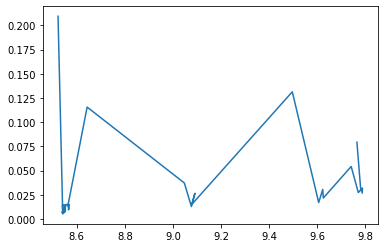

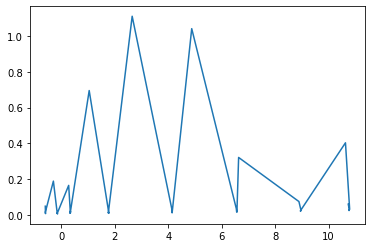

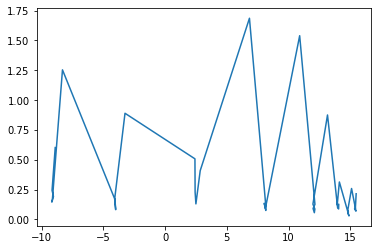

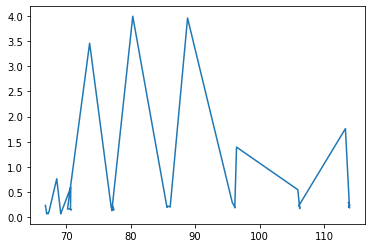

In [158]:
current_d = []
for i in range(0, noisy_mat['noisy_current_d'][0].shape[0], 250):
    current_d.append([np.mean(noisy_mat['noisy_current_d'][0][i:i+250]),
                     np.std(noisy_mat['noisy_current_d'][0][i:i+250])])
current_d = np.asarray(current_d)

plt.plot(current_d[:, 0], current_d[:, 1])
plt.show()

current_q = []
for i in range(0, noisy_mat['noisy_current_q'][0].shape[0], 250):
    current_q.append([np.mean(noisy_mat['noisy_current_q'][0][i:i+250]),
                     np.std(noisy_mat['noisy_current_q'][0][i:i+250])])
current_q = np.asarray(current_q)

plt.plot(current_q[:, 0], current_q[:, 1])
plt.show()


voltage_d = []
for i in range(0, noisy_mat['noisy_voltage_d'][0].shape[0], 250):
    voltage_d.append([np.mean(noisy_mat['noisy_voltage_d'][0][i:i+250]),
                     np.std(noisy_mat['noisy_voltage_d'][0][i:i+250])])
voltage_d = np.asarray(voltage_d)

plt.plot(voltage_d[:, 0], voltage_d[:, 1])
plt.show()


voltage_q = []
for i in range(0, noisy_mat['noisy_voltage_q'][0].shape[0], 250):
    voltage_q.append([np.mean(noisy_mat['noisy_voltage_q'][0][i:i+250]),
                     np.std(noisy_mat['noisy_voltage_q'][0][i:i+250])])
voltage_q = np.asarray(voltage_q)

plt.plot(voltage_q[:, 0], voltage_q[:, 1])
plt.show()

In [245]:
inp_out = []
for mat_file in noisy_mats:
    noisy_mat = loadmat(os.path.join(noisy_data_dir, mat_file))
    
    for i in range(0, noisy_mat['noisy_current_d'][0].shape[0], 250):
        id_mean = np.mean(noisy_mat['noisy_current_d'][0][i:i+250])
        iq_mean = np.mean(noisy_mat['noisy_current_q'][0][i:i+250])
        ud_mean = np.mean(noisy_mat['noisy_voltage_d'][0][i:i+250])
        uq_mean = np.mean(noisy_mat['noisy_voltage_q'][0][i:i+250])
        
        id_std = np.std(noisy_mat['noisy_current_d'][0][i:i+250])
        iq_std = np.std(noisy_mat['noisy_current_q'][0][i:i+250])
        ud_std = np.std(noisy_mat['noisy_voltage_d'][0][i:i+250])
        uq_std = np.std(noisy_mat['noisy_voltage_q'][0][i:i+250])
        
        inp_out.append([id_mean, iq_mean, ud_mean, uq_mean, 
                       id_std, iq_std, ud_std, uq_std])

inp_out = np.asarray(inp_out)
print (inp_out.shape)
percs = np.percentile(inp_out[:, 4:], 80, axis=0)
print (percs)

(1189, 8)
[0.06015636 0.24016714 1.92290413 2.54190784]


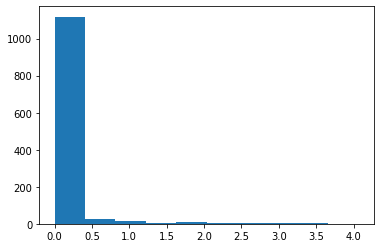

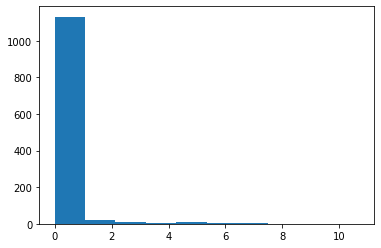

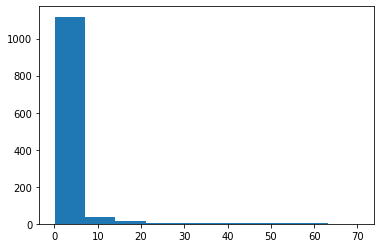

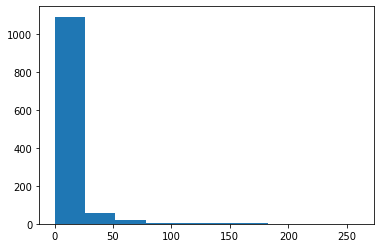

In [226]:
plt.hist(inp_out[:,4])
plt.show()
plt.hist(inp_out[:,5])
plt.show()
plt.hist(inp_out[:,6])
plt.show()
plt.hist(inp_out[:,7])
plt.show()

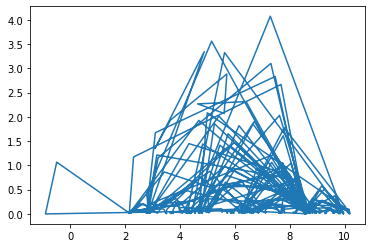

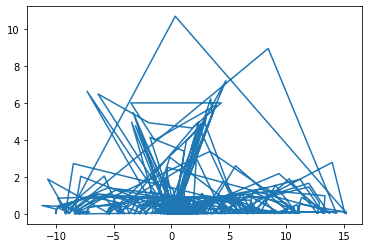

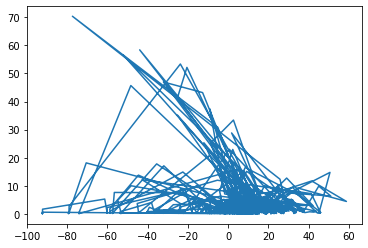

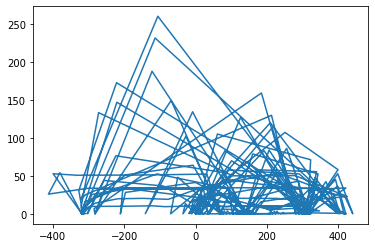

In [227]:
plt.plot(inp_out[:, 0], inp_out[:, 4])
plt.show()
plt.plot(inp_out[:, 1], inp_out[:, 5])
plt.show()
plt.plot(inp_out[:, 2], inp_out[:, 6])
plt.show()
plt.plot(inp_out[:, 3], inp_out[: ,7])
plt.show()